#### Regression

In [36]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from bpitnorm.modules.BatchPitNormalization import BatchPitNorm1d

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.genfromtxt("Data/OnlineNewsPopularity.csv", delimiter=",", skip_header=1)[:, 1:]
data = data[~(np.isnan(data)).any(axis=1)]
data = data[~(np.isinf(data)).any(axis=1)]
print("Number of features: ", data.shape[1])
print("Number of datapoints: ", data.shape[0])

def data_split(data, seed):
  X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=seed)
  y_train_raw = y_train_raw.reshape(-1, 1)
  y_test_raw = y_test_raw.reshape(-1, 1)

  scaler1 = StandardScaler()
  scaler_x = scaler1.fit(X_train_raw)
  X_train = scaler_x.transform(X_train_raw)
  X_test = scaler_x.transform(X_test_raw)

  scaler2 = StandardScaler()
  scaler_y = scaler2.fit(y_train_raw)
  y_train = scaler_y.transform(y_train_raw)
  y_test = scaler_y.transform(y_test_raw)

  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device).reshape(-1, 1)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device=device)
  y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device=device)
  return X_train, y_train, X_test, y_test, scaler_y

Number of features:  60
Number of datapoints:  39644


In [4]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

def train_model(model, loops):
    model.to(device=device)
    r2score_lst = np.zeros(loops)
    meanAbsoluteError_lst = np.zeros(loops)
    torch.backends.cudnn.deterministic = True
    seeds = range(loops)

    for i, seed in zip(range(loops), seeds):
        X_train, y_train, X_test, y_test, scaler_y = data_split(data, seed)
        torch.manual_seed(seed)
        loss_fn = nn.MSELoss().to(device=device)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=200, shuffle=True)
        n_epochs = 30
        for epoch in range(n_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device=device)
                y_batch = y_batch.to(device=device)
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()
        
        model.eval()
        y_test_inverse = scaler_y.inverse_transform(y_test.cpu())
        y_pred = model(X_test)
        y_pred = scaler_y.inverse_transform(y_pred.cpu().detach().numpy())
        r2score = r2_score(y_test_inverse, y_pred)
        r2score_lst[i] = r2score
        meanAbsoluteError = mean_absolute_error(y_test_inverse, y_pred)
        meanAbsoluteError_lst[i] = meanAbsoluteError
    return r2score_lst, meanAbsoluteError_lst

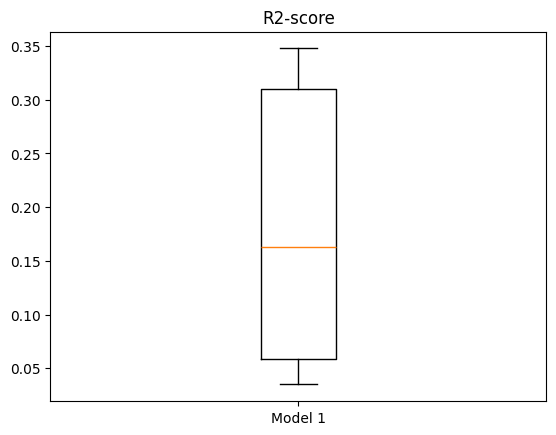

Mean of all shares: 3395.3801836343455


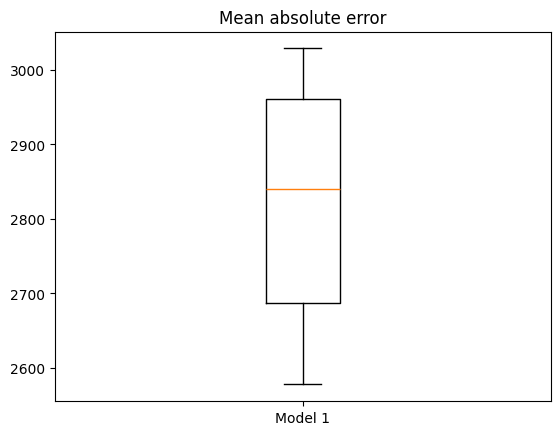

In [13]:
model1 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1))

model1.to(device=device)

r2Score1, MAE1 = train_model(model1, 10)
plt.boxplot(r2Score1, labels=["Model 1"])
plt.title("R2-score")
plt.show()
print(f"Mean of all shares: {np.mean(data[:, -1])}")
plt.boxplot(MAE1, labels=["Model 1"])
plt.title("Mean absolute error")
plt.show()

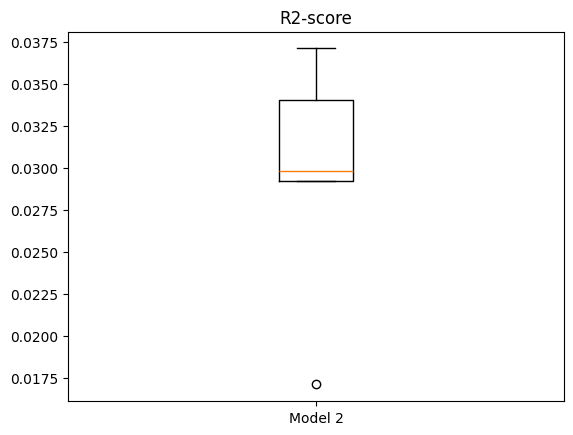

Mean of all shares:  3395.3801836343455


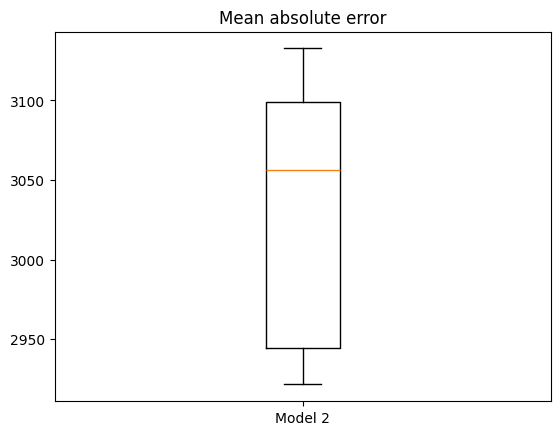

In [33]:
model2 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    nn.BatchNorm1d(100),
    nn.Sigmoid(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1))

model2.to(device=device)

r2Score2, MAE2 = train_model(model2, 5)
plt.boxplot(r2Score2, labels=["Model 2"])
plt.title("R2-score")
plt.show()
print("Mean of all shares: ", np.mean(data[:, -1]))
plt.boxplot(MAE2, labels=["Model 2"])
plt.title("Mean absolute error")
plt.show()

/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q25 = torch.quantile(input=data, q=.25, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:104: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  q75 = torch.quantile(input=data, q=.75, dim=0)
/home/ubuntu/batch-pit-normalization/bpitnorm/modules/BatchPitNormalization.py:103: Us

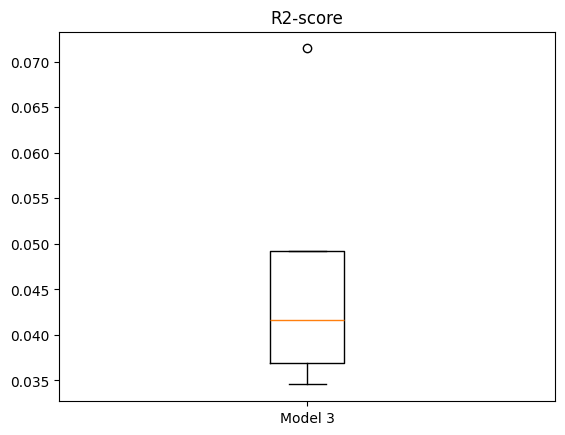

Mean of all shares:  3395.3801836343455


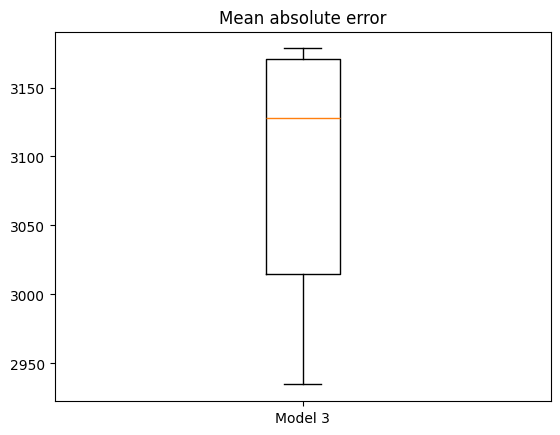

In [34]:
model3 = nn.Sequential(
    nn.Linear(data.shape[1]-1, 100),
    BatchPitNorm1d(num_features=100, num_pit_samples=200, take_num_samples_when_full=0, dev=device),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Sigmoid(),
    nn.Linear(10, 1))
model3.to(device=device)

r2Score3, MAE3 = train_model(model3, 5)
plt.boxplot(r2Score3, labels=["Model 3"])
plt.title("R2-score")
plt.show()
print("Mean of all shares: ", np.mean(data[:, -1]))
plt.boxplot(MAE3, labels=["Model 3"])
plt.title("Mean absolute error")
plt.show()

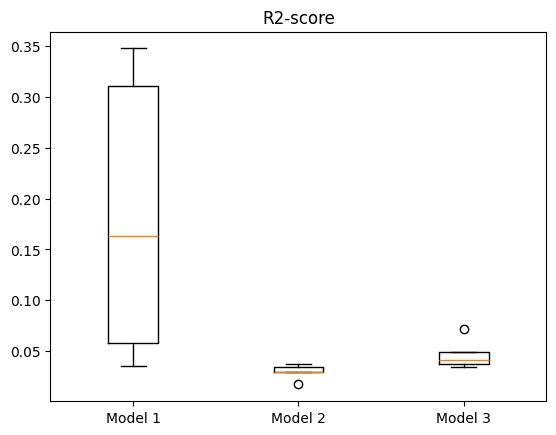

Mean shares of all news:  3395.3801836343455


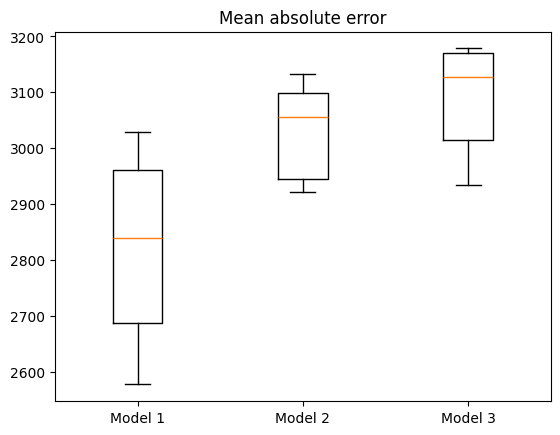

In [35]:
plt.boxplot([r2Score1, r2Score2, r2Score3], labels=["Model 1", "Model 2", "Model 3"])
plt.title("R2-score")
plt.show()
print("Mean shares of all news: ", np.mean(data[:, -1]))
plt.boxplot([MAE1, MAE2, MAE3], labels=["Model 1", "Model 2", "Model 3"])
plt.title("Mean absolute error")
plt.show()

Model 1: Without any batch layer 

Model 2: With ordinary batch normalization layer.

Model 3: With batch pit normalization layer.

All of the models is very bad. The best model according to R2-score is the first one without any batch normalization layers. It seems to be around 0.16 which is not good since 1 is the goal. 

The models, according to mean absolute error is also bad when we compare to the mean of all the online news shares that is around 3395. Model 1 seems to be the best and has mean absolute error around 2830 which is close to the mean of all shares (3395).